# Flu Shot Learnign - Machine Learning Final Project

To run this colab, it is required to have the competition's data files in the following manner: \
`<googleDriveRoot>/APC/data`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from pathlib import Path

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Project data in google drive
#DATA_PATH = Path.cwd()/"drive"/"MyDrive"/"APC"/"data";

# Project data from repository
DATA_PATH = "../data";

features_train = pd.read_csv(
    DATA_PATH+"/training_set_features.csv",
    index_col="respondent_id"
)

labels_train = pd.read_csv(
    DATA_PATH+"/training_set_labels.csv",
    index_col="respondent_id"
)

In [7]:
# View the training features
print("features_train.shape", features_train.shape);
features_train.head()

# View the training labels
print("labels_train.shape", labels_train.shape)
labels_train.head()

# no error, no problem
np.testing.assert_array_equal(features_train.index.values, labels_train.index.values)

features_train.shape (26707, 35)
labels_train.shape (26707, 2)


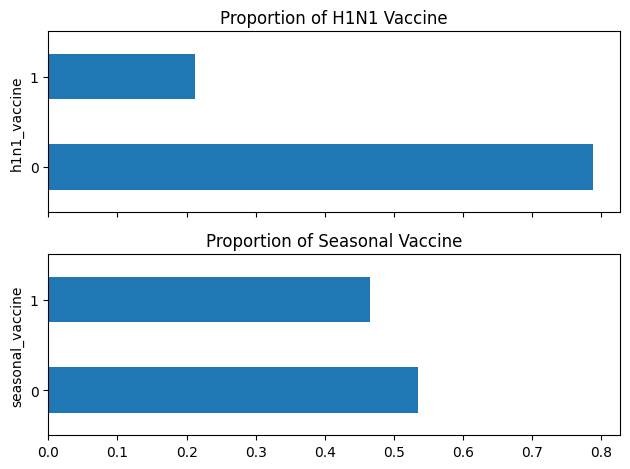

In [8]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_train.shape[0]

(labels_train['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_train['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

For seasonal vaccines, the classes are pretty much balenced. But this is not the case for H1N1, where roughly 20% of people got the shot.

In [55]:
print("Correlation: "+ str((labels_train["h1n1_vaccine"]
     .corr(labels_train["seasonal_vaccine"], method="pearson")
)))

pd.crosstab(
    labels_train["h1n1_vaccine"], 
    labels_train["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

Correlation: 0.37714265306144495


seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [16]:
# Join both features and Labels in one matrix
joined_train = features_train.join(labels_train)
print(joined_train.shape)
joined_train.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [29]:
def vaccination_feature_plot(col, target, data, ax = None):
    """This function will generate a stack bar chart of vaccination rate
    in proportion to a given feature"""
    counts = (joined_train[[target, col]]
                .groupby([target, col])
                .size()
                .unstack(target))
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

We can plot the rate of vaccination in a given feature column, for both types of vaccines.

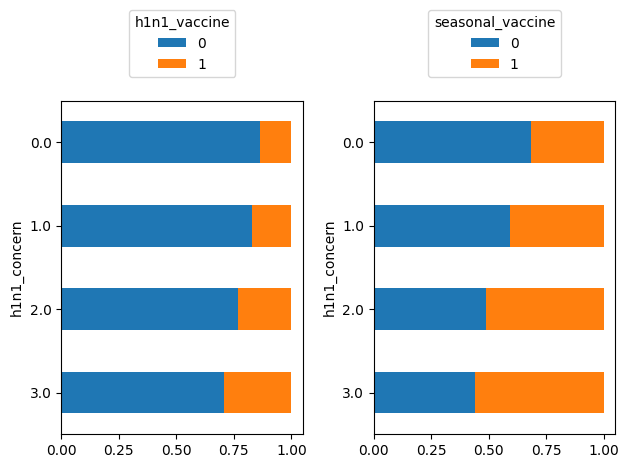

In [36]:
fig, ax = plt.subplots(
    1, 2
)

vaccination_feature_plot('h1n1_concern', 'h1n1_vaccine', joined_train, ax=ax[0])
vaccination_feature_plot('h1n1_concern', 'seasonal_vaccine', joined_train, ax=ax[1])

ax[0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

#### Plotting several columns:

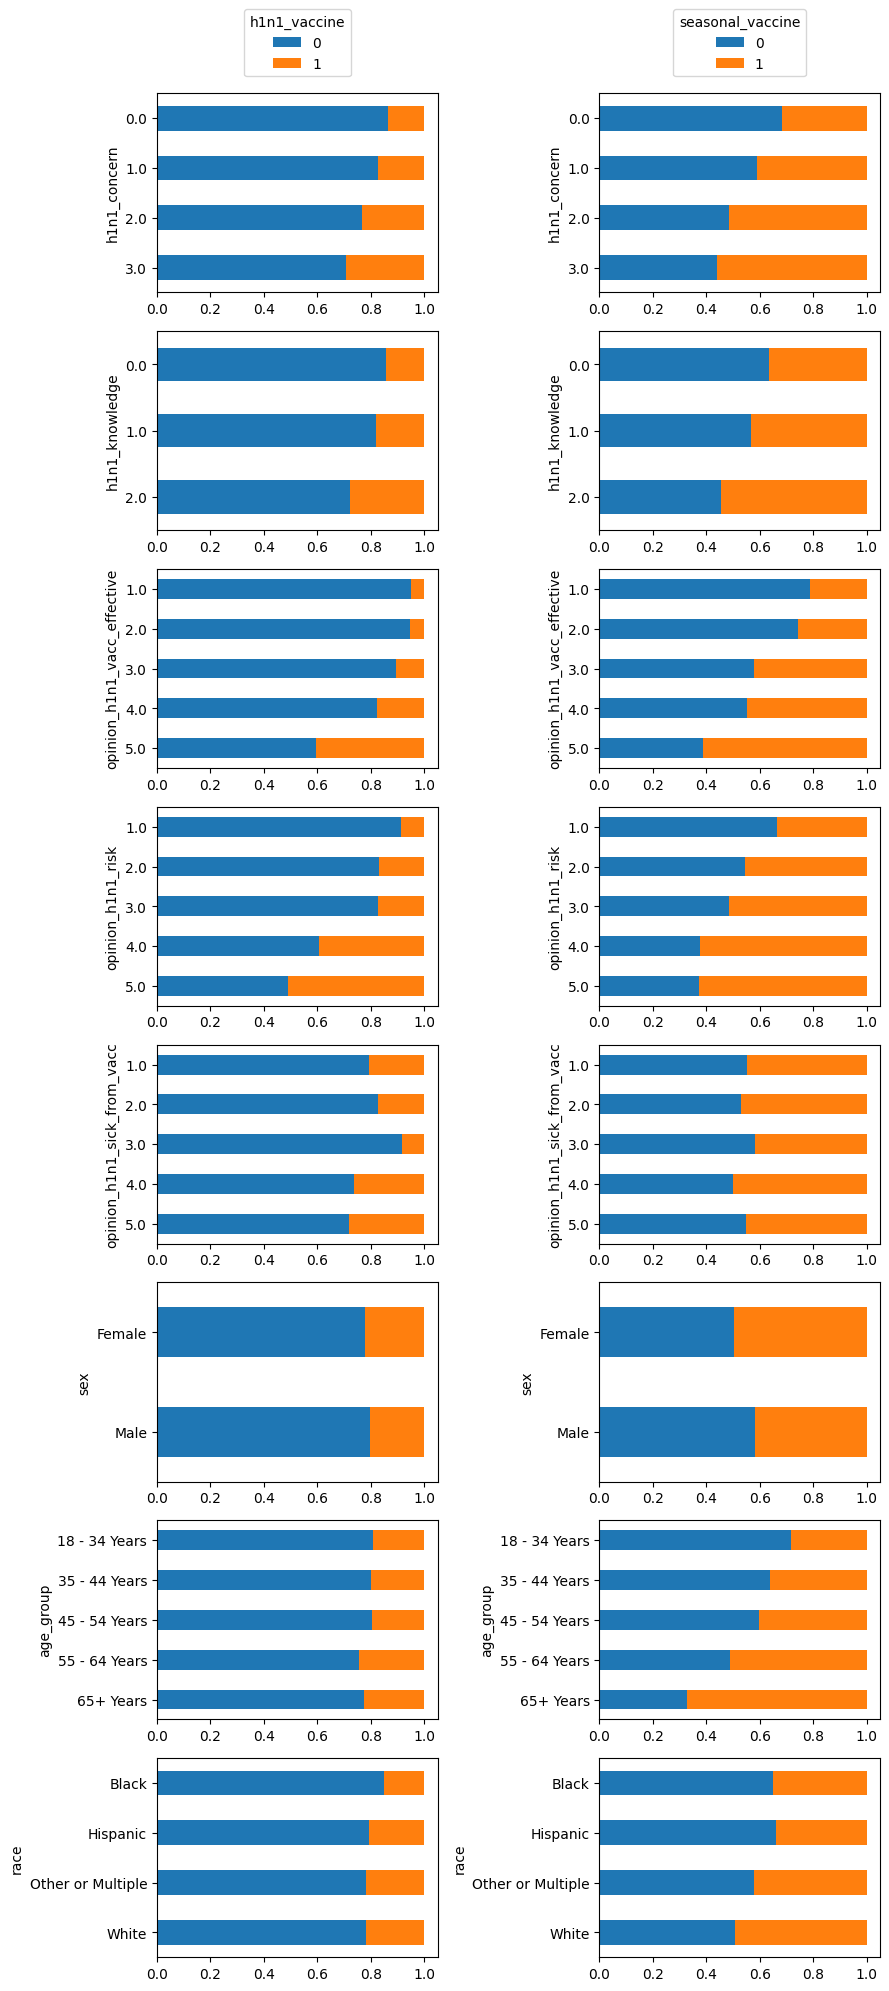

In [38]:
#print(joined_train.columns.to_list())
cols= [
    'h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'sex', 'age_group', 'race'
]

fig, ax = plt.subplots(
    len(cols), 2, figsize =(9, len(cols)*2.5)
)

for i in range(len(cols)):
    vaccination_feature_plot(cols[i], 'h1n1_vaccine', joined_train, ax=ax[i, 0])
    vaccination_feature_plot(cols[i], 'seasonal_vaccine', joined_train, ax=ax[i, 1])

ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

### Prediction Models

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 1337

Initially we'll experiment with a logistic regression model considering only the numerical features variables. For this it is required to apply some processing to the feature set:
- **Scaling**: Transform all features to be on the same scale.
- **NA Imputation**: Logistic regression does not handle NA values (i.e when survey respondents leave out answers unfilled). Median imputation will be utilized, which fills these missing values with the median from the training data.

*Note:* For non numerical categorical variables, one-hot encoding and ordinal encoding can be utilized

In [59]:
# Just the numerical features
numeric_cols = features_train.columns[features_train.dtypes != "object"].values

# Scaling and Imputation steps
numeric_preprocessing = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simpleImputer', SimpleImputer(strategy='median'))
])

# Apply the preprocessing steps to a given feature column
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_preprocessing, numeric_cols)
    ], 
    remainder="drop"
)

In [61]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", C=1)
)

# FULL MODEL PIPELINE

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators)
])
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simpleImputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'b...
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'], dtype=object))])),
                ('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression(C=1)))])

#### Training and Evaluation

In [62]:
# Split the training data into two data sets, training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(
    features_train,
    labels_train,
    test_size=0.33,
    shuffle=True,
    stratify=labels_train,
    random_state=RANDOM_SEED
)

# Train the model
full_pipeline.fit(X_train, y_train)

preds = full_pipeline.predict_proba(X_eval)
preds

[array([[0.97444008, 0.02555992],
        [0.91393352, 0.08606648],
        [0.92507422, 0.07492578],
        ...,
        [0.84426596, 0.15573404],
        [0.82764693, 0.17235307],
        [0.32153228, 0.67846772]]),
 array([[0.88441317, 0.11558683],
        [0.79001149, 0.20998851],
        [0.80649735, 0.19350265],
        ...,
        [0.5466243 , 0.4533757 ],
        [0.45357974, 0.54642026],
        [0.09134121, 0.90865879]])]

For the predictions, the pipeline has returned two arrays of predictions, one for each label `seasonal_vaccine` and `h1n1_vaccine`. Within each vector there are two classes, 0 and 1, so we'll only need the values of the second column (which correspond to the probability of having taken the vaccine)

In [64]:
y_preds = pd.DataFrame({
    "h1n1_vaccine": preds[0][:, 1],
    "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
y_preds.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6518,0.025560,0.115587
25535,0.086066,0.209989
14807,0.074926,0.193503
7008,0.213239,0.561864
501,0.096330,0.458094


#### Performance Metrics (ROC)

In [76]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

0.8328071201706476


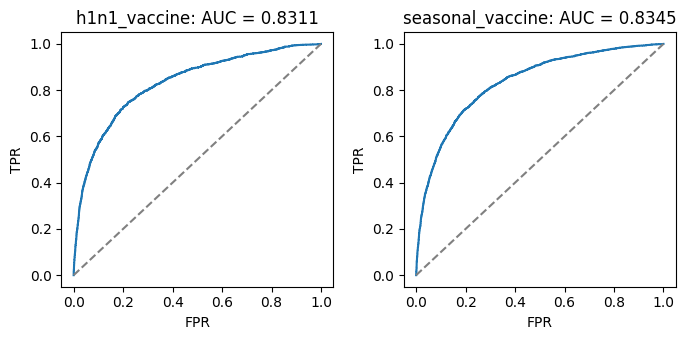

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(y_eval['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(y_eval['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

# Final score,
print(roc_auc_score(y_eval, y_preds))